In [1]:
#Load libraries
import numpy as np
import pandas as pd

In [2]:
#Read in data
url = 'https://raw.githubusercontent.com/statzenthusiast921/ATP_Analysis/main/main/data/model_df_v2.parquet.gzip'

df = pd.read_parquet(url)
df.shape

(203632, 56)

#### Build model

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Choose features and response
y = df['outcome']
X = df[['num_aces','num_dfs','serve1_in_perc','player_age','surface','num_brkpts_saved','num_brkpts_faced']]

#One Hot Encode surface
one_hot = pd.get_dummies(X['surface'])
X = X.drop('surface',axis=1)
X = X.join(one_hot)

# scale = StandardScaler()
# scaledX = scale.fit_transform(X)

#X_train, X_test, y_train, y_test = train_test_split(scaledX, y, test_size=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(142542, 10)
(142542,)
(61090, 10)
(61090,)


In [4]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear', random_state=0)
logreg.fit(X_train, y_train)

/Users/jonzimmerman/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jonzimmerman/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jonzimmerman/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


LogisticRegression(random_state=0, solver='liblinear')

In [5]:
import shap
#explainer = shap.Explainer(logreg, X_train, feature_names=X.columns)
masker = shap.maskers.Independent(data = X_train)
explainer = shap.LinearExplainer(logreg, masker = masker)
shap_values = explainer(X_test)

#### Plot shap plots

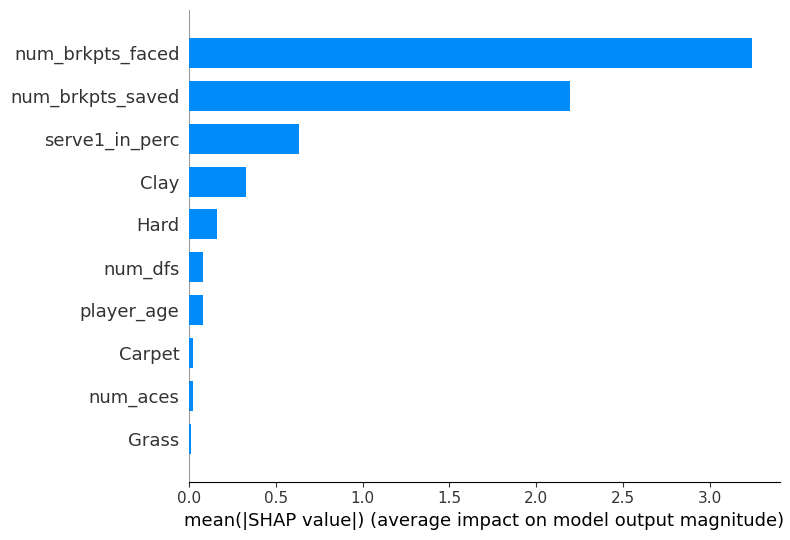

In [6]:
shap.initjs()
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, plot_type="bar")

#### Force plots, like the one shown below, allow you to see how features contributed to the model’s prediction for a specific observation. This is perfect for being able to explain to someone exactly how your model arrived at the prediction it did for a specific observation.


#### f(x) is on the log-odds scale

In [7]:
shap.initjs()
ind = 1004
shap.plots.force(shap_values[ind])

In [8]:
def convert_log_odds_to_prob(number):
    log_odds = number
    odds = np.exp(log_odds)
    prob = odds / (1 + odds)
    return round(prob,5)

#### Predicted probability from example above is 0.31, likely a loss

In [9]:
convert_log_odds_to_prob(-0.78)

0.31432

In [10]:
#Check the predictions
y_test = y_test.reset_index()
X_test = X_test.reset_index()

full_test = pd.merge(y_test, X_test, on='index', how='inner')
del full_test['index']

print(y_test.shape)
print(X_test.shape)
print(full_test.shape)

(61090, 2)
(61090, 11)
(61090, 11)


In [11]:
full_test.loc[1004]

outcome               0.0
num_aces              5.0
num_dfs               5.0
serve1_in_perc       34.0
player_age           23.7
num_brkpts_saved      1.0
num_brkpts_faced      4.0
Carpet              False
Clay                False
Grass               False
Hard                 True
Name: 1004, dtype: object

In [12]:
shap.initjs()
ind = 1
shap.plots.force(shap_values[ind])

#### Predicted probability from example above is 0.89, likely a winner

In [13]:
convert_log_odds_to_prob(2.07)

0.88795

In [14]:
full_test.loc[1]

outcome               1.0
num_aces              4.0
num_dfs               0.0
serve1_in_perc       76.0
player_age           27.3
num_brkpts_saved      1.0
num_brkpts_faced      3.0
Carpet              False
Clay                False
Grass               False
Hard                 True
Name: 1, dtype: object

#### Waterfall plots are designed to display explanations for individual predictions, so they expect a single row of an Explanation object as input. The bottom of a waterfall plot starts as the expected value of the model output, and then each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output over the background dataset to the model output for this prediction.

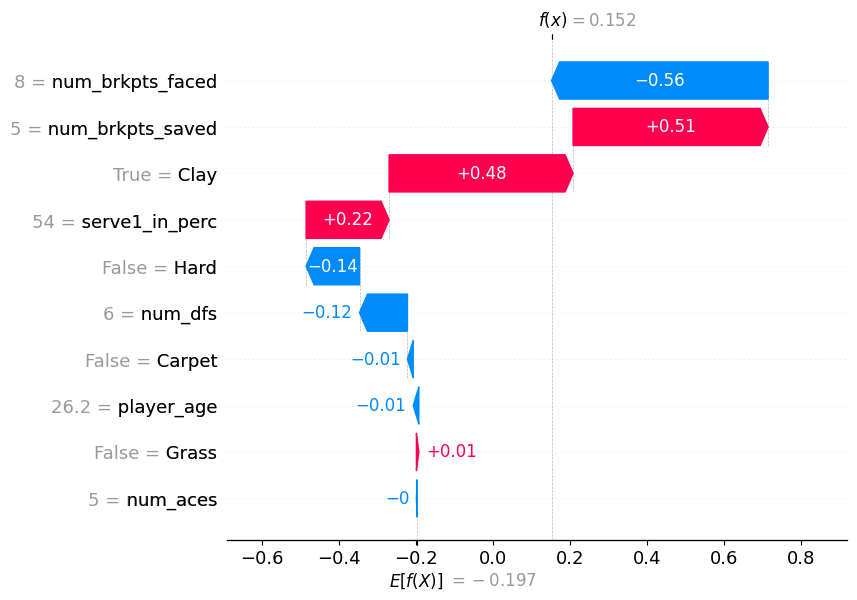

In [15]:
shap.initjs()
shap.plots.waterfall(shap_values[1003], max_display=14)

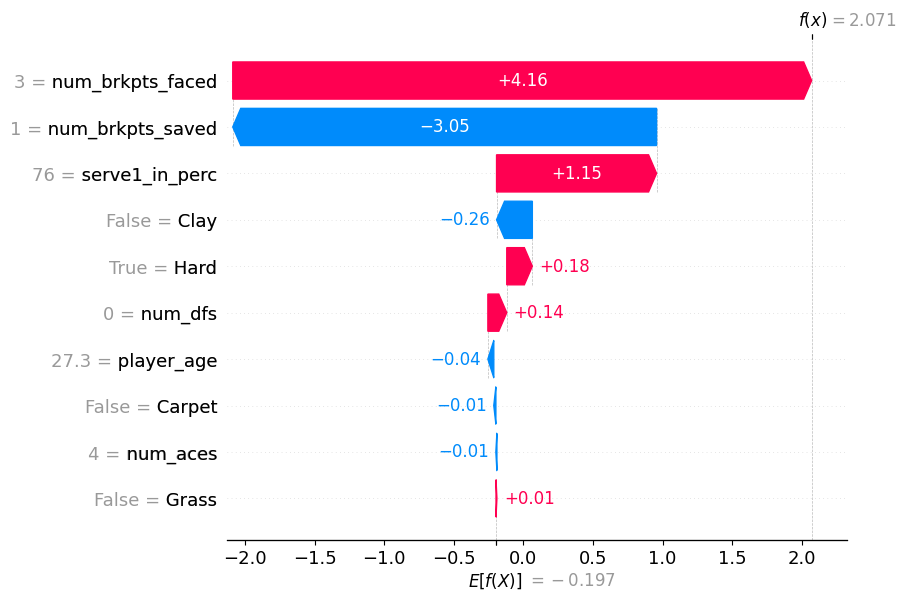

In [16]:
shap.initjs()
shap.plots.waterfall(shap_values[1], max_display=14)

#### The x-axis is the value of the feature (from the X matrix, stored in shap_values.data).

#### The y-axis is the SHAP value for that feature (stored in shap_values.values), which represents how much knowing that feature’s value changes the output of the model for that sample’s prediction. 

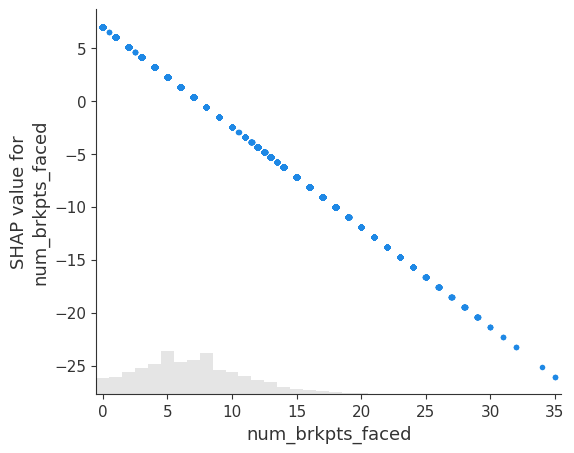

In [17]:
shap.initjs()
shap.plots.scatter(shap_values[:, "num_brkpts_faced"])